In [112]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from ipywidgets import interact, interactive

In [63]:
# Load classifiers
classifiers = {}

def load_meta(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.meta')
    with open(path, 'r') as f:
        return json.load(f)

def load_clf(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.pkl')
    return joblib.load(path)

def clfs_are_same_version(clfs):
    hashes = [classifier['meta']['git_hash'] for tag_id, classifier in classifiers.items()]
    return len(set(hashes)) == 1

for f in os.listdir("./models/"):
    if f.endswith(".pkl"):
        filename = os.path.splitext(f)[0]
        print('Loading model', filename)
        meta = load_meta('./models/', filename)
        clf = load_clf('./models/', filename)
        tag_id = meta['tag_id']
        classifiers[tag_id] = {
            'clf': clf,
            'meta': meta
        }
        
# Version verification
assert clfs_are_same_version(classifiers), 'Warning loaded classifiers were not generated on the same git hash!'

Loading model tag_5
Loading model tag_6
Loading model tag_3
Loading model tag_2
Loading model tag_1
Loading model tag_11
Loading model tag_9


---
## Import Dataset

In [65]:
df = pd.read_csv('./data/features-total-4a115a8.csv')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,revision_id,tag_id
0,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,0.513889,1024.000000,34.0,34.0,0.0,0.0,0.0,0.0,228189784,12
1,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,0.308994,4.126739,14.0,14.0,0.0,0.0,0.0,0.0,730449352,12
2,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.434896,85.525822,67.0,0.0,0.0,0.0,2.0,0.0,216224416,12
3,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,0.0,539338621,12
4,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,0.428264,342.595182,10.0,10.0,0.0,0.0,0.0,0.0,746191686,12


---
## Preprocessing

In [69]:
# Preprocessing utils
class VandalismEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, tag_ids):
        self.tag_ids = tag_ids
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['is_vandalism'] = X.tag_id.isin(self.tag_ids)
        X = X.drop(['tag_id'], axis=1)
        return X

    def fit_transform(self, X, y):
        return self.transform(X)
    
class RevisionGrouper(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.groupby(X.index).apply(self._vandalism_revision_or_first)
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def _vandalism_revision_or_first(self, group):
        vandalism_revisions = group.loc[group['is_vandalism'] == True]
        return vandalism_revisions.iloc[0] if len(vandalism_revisions) > 0 else group.iloc[0]

class FeatureSelector(BaseEstimator, TransformerMixin):        
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns != None:
            # Do not remove 'is_vandalism'
            self.columns.append('is_vandalism')
            X = X[self.columns]
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [106]:
# Evaluation utils
def plot_confusion_matrix(y_true, y_pred):
    vandalism_count = y_true.value_counts()[True]
    no_vandalism_count = y_true.value_counts()[False]
    cfn_matrix = confusion_matrix(y_true, y_pred)
    cfn_norm_matrix = np.array([[1.0/no_vandalism_count, 1.0/no_vandalism_count], [1.0/vandalism_count, 1.0/vandalism_count]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix, annot=True, fmt="d", linewidths=0.5, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix, linewidths=0.5, annot=True, ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('Classification Report')
    classes = ['No Vandalism', 'Vandalism']
    print(classification_report(y_true, y_pred, target_names=classes))

In [76]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

In [82]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

Feature config: all , Features after preprocessing: 85


In [103]:
def plot_scores(scores):
    print('Cross validation scores')
    scores = list(scores.items())[2:]

    for score in scores:
        sns.lineplot(range(0, 10), score[1], label=score[0])
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [83]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [84]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (4455, 84)
y train (4455,)
X test (1486, 84)
y test (1486,)


In [102]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
clf = VotingClassifier(estimators, voting='soft')
train_scores = cross_validate(clf, X_train, y_train,
                              scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                              cv=10, n_jobs=-1, return_train_score=False)

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


{'fit_time': array([14.33909607, 14.60953498, 14.09787893, 14.77123213, 13.01943922,
        13.20302391, 13.29576397, 13.54998493,  7.30659509,  7.2196188 ]),
 'score_time': array([3.75420594, 3.7468071 , 3.75034976, 3.74057484, 3.76911283,
        3.78652716, 3.76601601, 3.813591  , 3.71307611, 3.72127318]),
 'test_f1': array([0.8021978 , 0.82608696, 0.79245283, 0.81940701, 0.82644628,
        0.82262211, 0.85483871, 0.85790885, 0.80874317, 0.81300813]),
 'test_precision': array([0.81564246, 0.83060109, 0.79032258, 0.8172043 , 0.84269663,
        0.78431373, 0.84574468, 0.84656085, 0.81318681, 0.81081081]),
 'test_recall': array([0.78918919, 0.82162162, 0.79459459, 0.82162162, 0.81081081,
        0.86486486, 0.86413043, 0.86956522, 0.80434783, 0.81521739]),
 'test_roc_auc': array([0.91692037, 0.92194263, 0.91854613, 0.92454178, 0.92638501,
        0.92753443, 0.93203398, 0.95509537, 0.91412627, 0.92011915]),
 'test_accuracy': array([0.83856502, 0.85650224, 0.82735426, 0.84977578, 0.8

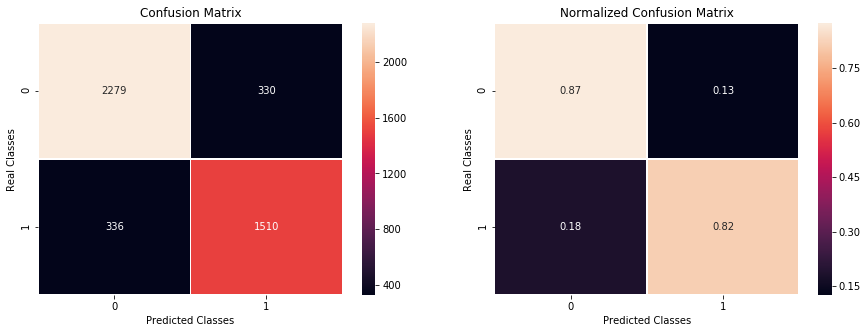

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.87      0.87      0.87      2609
   Vandalism       0.82      0.82      0.82      1846

 avg / total       0.85      0.85      0.85      4455



In [113]:
y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
plot_confusion_matrix(y_train, y_train_predict)

Cross validation scores


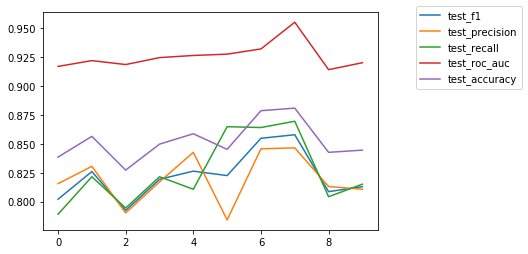

In [105]:
plot_scores(train_scores)

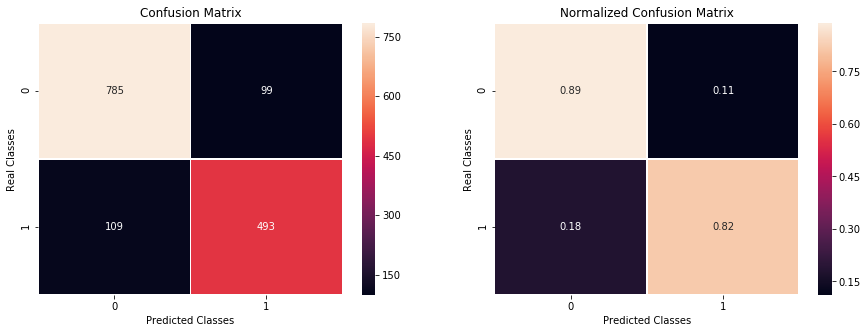

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.88      0.89      0.88       884
   Vandalism       0.83      0.82      0.83       602

 avg / total       0.86      0.86      0.86      1486



In [115]:
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

plot_confusion_matrix(y_test, y_test_predict)